<a href="https://colab.research.google.com/github/yoshithedinosaur/confluency-analysis-tool/blob/main/confluency_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Preamble
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from PIL import Image
from scipy.fft import fftn, fftshift
from skimage import data, segmentation, feature, future, color, morphology
from skimage.color import rgb2gray
from skimage.filters import difference_of_gaussians, window
from sklearn import datasets, svm
from sklearn.ensemble import RandomForestClassifier


# Tool to read files from google drive
from google.colab import drive
drive.mount('/content/drive')

# Checks that path is found in google drive
!ls "/content/drive/Shareddrives/IPRO Fall 2022 (iGEM)/SCRC - Cholesterol Project"

Mounted at /content/drive
'Assay Team'	   'Cholest.IPRO.Supply log.gsheet'  'Team Charter.gdoc'
'Before we start'  'Design Team'		     'Team Collaboration'
'Cell Team'	   'Goals .pptx'		     'Team Members.xlsx'


In [ ]:
def fourier_bandpass(image):
  image = asarray(image)
  wimage = image * window('hann', image.shape)  # window image to improve FFT
  filtered_image = difference_of_gaussians(image, 1.5)
  filtered_wimage = filtered_image * window('hann', image.shape)
  #im_f_mag = fftshift(np.abs(fftn(wimage)))
  #fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))
  return asarray(filtered_image)

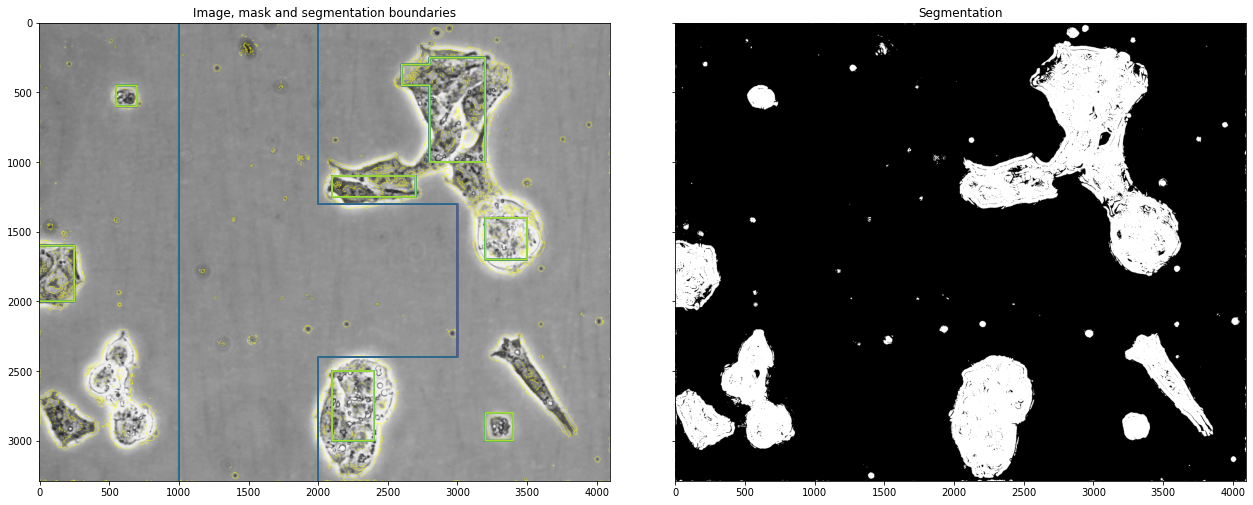

In [ ]:
image_dir = "/content/drive/Shareddrives/IPRO Fall 2022 (iGEM)/SCRC - Cholesterol Project/Cell Team/Cell Pictures/"
training_image = Image.open(image_dir + "Thaw/20220918/HEPG2.splitP2A.day 12022-09-18-10-35-51-333.jpg")
#test_image = Image.open(image_dir + "Thaw/20220907/HEPG2.thawP1.2022-09-07-13-26-03-270.jpg")
#test_image = Image.open(image_dir + "Thaw/20220917/HEPG2.thawP1.day 102022-09-17-10-21-08-445.jpg")

filtered_image = fourier_bandpass(training_image)

#Rectangular boundries for training
training_labels = np.zeros(filtered_image.shape[:2], dtype=np.uint8)
training_labels[:3288,1000:2000] = 1
training_labels[1300:2400, 1000:3000] = 1
training_labels[250:1000, 2800:3200] = 2
training_labels[300:450, 2600:3000] = 2
training_labels[2500:3000, 2100:2400] = 2
training_labels[1400:1700, 3200:3500] = 2
training_labels[1100:1250, 2100:2700] = 2
training_labels[450:600, 550:700] = 2
training_labels[2800:3000, 3200:3400] = 2
training_labels[1600:2000, :250] = 2

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features, intensity=True, edges=False, texture=True, sigma_min=sigma_min, sigma_max=sigma_max)
features = features_func(filtered_image)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(asarray(training_image), result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap='gray')
ax[1].set_title('Segmentation')
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)

In [ ]:
#iris = datasets.load_iris()
#X, y = iris.data, iris.target

#clf = svm.SVC()
#clf.fit(X, y)

##########################
# SAVE-LOAD using joblib #
##########################
import joblib

# save
joblib.dump(clf, image_dir + "Confluency Tool Python Scripts/model.joblib") 

# load
#clf2 = joblib.load("model.joblib")

#clf2.predict(X[0:1])

['/content/drive/Shareddrives/IPRO Fall 2022 (iGEM)/SCRC - Cholesterol Project/Cell Team/Cell Pictures/Confluency Tool Python Scripts/model.joblib']